# APPROXIMATE ARC LENGTH PARAMETRIZATION USING CUBIC BEZIER CURVES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import kron
import cvxpy as cp
%matplotlib inline

In [29]:
#track

trackx = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, \
                  0.8 ,0.5 ,0.8 ,0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.0, 0.0, 0.0, 0.0 ]) 
tracky = np.array([0.05, 0.3, 0.4, 0.2, 0.2, 0.0, 0.0, 0.0, 0.05, \
                  0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.5, 0.3, 0.3, 0.5, 0.5, 0.5, 0.45, 0.4, 0.3, 0.2, 0.1 ]) 
waypoints = np.vstack([trackx,tracky]).T

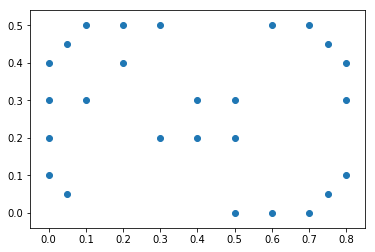

In [30]:
plt.scatter(trackx, tracky)


In [31]:
def interpolateclosedBezier(waypoints):
    n = len(waypoints)
    M = np.zeros([n,n])

    #build M
    tridiagel = np.matrix([[1, 4, 1]])
    for idx in range(n-2):
        M[idx+1:idx+2, idx:idx+3] = tridiagel

    M[0,0:2]= tridiagel[:,1:3]
    M[-1,-2:]= tridiagel[:,0:2]
    M[0:2,-1] = tridiagel[:,0].reshape(1,-1)
    M[-1,0] = tridiagel[:,0].reshape(1,-1)


    #build sol vector
    s =np.zeros([n,2])
    for idx in range(n-1):
        s[idx,:] = 2*(2*waypoints[idx,:] + waypoints[idx+1,:])
    s[-1:] = 2*(2*waypoints[-1,:] + waypoints[0,:])
    
    #solve for a & b
    Ax = np.linalg.solve(M,s[:,0])
    Ay = np.linalg.solve(M,s[:,1])

    a = np.vstack([Ax,Ay])
    b = np.zeros([2,n])

    b[:,:-1] = 2*waypoints.T[:,1:] - a[:,1:]
    b[:,-1] = 2*waypoints.T[:,0] - a[:,0]
    
    return a, b
    
def evalclosedBezier(waypoints, a, b, t):
    segment = np.floor(t)
    segment = np.int(segment)
    n = len(waypoints)
    if segment>=n:
        t =n-0.0001
        segment = n-1
    elif t<0:
        t = 0
    t_val = t-segment
    coords = np.power(1 - t_val, 3) * waypoints.T[:,segment] + 3 * np.power(1 - t_val, 2) * t_val * a[:,segment]\
    + 3 * (1 - t_val) * np.power(t_val, 2) * b[:,segment] + np.power(t_val, 3) * waypoints.T[:,np.int(np.mod(segment+1,n))]

    return coords

def computeT(coef,order, s):
    res = 0
    for idx in range(order):
        res += coef[idx]*np.power(s,order-idx)
    return res


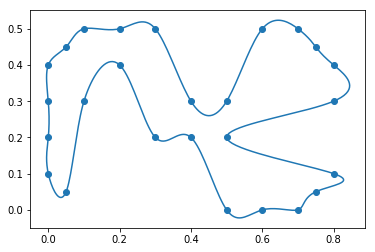

In [32]:
npoints = 500
a, b = interpolateclosedBezier(waypoints)
coords =[]
tvals = np.linspace(0, 26, npoints)
for t in tvals:
    coords.append(evalclosedBezier(waypoints, a, b, t))

coords = np.array(coords)
coords.shape

plt.plot(coords[:,0],coords[:,1])
plt.scatter(trackx, tracky)

Text(0, 0.5, 's (approx. distance traveled) [m] ')

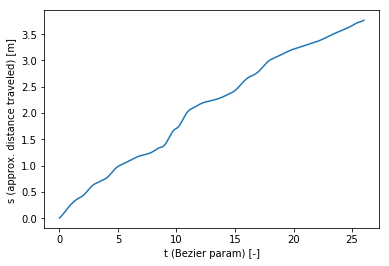

In [33]:
#compute approx distance to arc param
dists = []

for idx in range(npoints):
    dists.append(np.sqrt(np.sum(np.square(coords[idx,:]-coords[np.mod(idx+1,npoints-1),:]))))
    
dists = np.cumsum(np.array(dists))

plt.figure()
plt.plot(tvals, dists)
plt.xlabel("t (Bezier param) [-]")
plt.ylabel("s (approx. distance traveled) [m] ")

In [55]:
#interpolation order
order = 8
norm = 2

coef = cp.Variable((order,1))
#create regressor
A = dists.reshape(-1,1)
for idx in range(order-1):
    print('ord conc %f', idx+2)
    A = np.concatenate((np.power(dists,idx+2).reshape(-1,1),A), axis =1)
y = tvals.reshape(-1,1)

objective = cp.Minimize(cp.norm(A@coef-y,norm))
constraint =[(A@coef)[-1] == y[-1]]
prob = cp.Problem(objective, constraint)
result = prob.solve(solver = 'ECOS', verbose=True)

coeffs = coef.value

ord conc %f 2
ord conc %f 3
ord conc %f 4
ord conc %f 5
ord conc %f 6
ord conc %f 7
ord conc %f 8

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+04  4e-01  1e-06  1e+00  5e+03    ---    ---    3  1  - |  -  - 
 1  -4.663e-01  +1.470e-02  +1e+02  1e-04  1e-08  5e-01  5e+01  0.9890  1e-04   3  4  4 |  0  0
 2  +8.845e-01  +9.268e-01  +7e+00  1e-06  4e-09  4e-02  3e+00  0.9370  2e-04   7  8  7 |  0  0
 3  +5.870e+00  +5.917e+00  +8e-01  3e-07  1e-09  5e-02  4e-01  0.9890  8e-03   1  1  1 |  0  0
 4  +7.114e+00  +7.126e+00  +2e-01  4e-07  5e-10  1e-02  1e-01  0.9591  2e-02   1  1  1 |  0  0
 5  +6.623e+00  +6.640e+00  +8e-03  2e-06  3e-11  2e-02  9e-03  0.2819  2e-01   1  1  1 |  0  0
 6  +4.794e+00  +4.797e+00  +1e+00  6e-07  1e-09  2e-03  7e-01  0.9890  7e-01   1  1  1 |  0  0
 7  +2.748e+00  +2.811e+00  +8e+00  4e-07  1

Text(0, 0.5, 's (approx. distance traveled) [m] ')

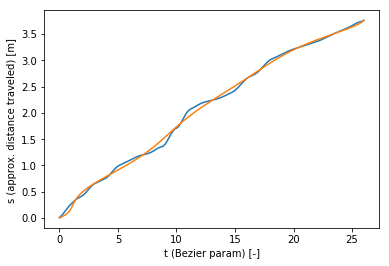

In [56]:
smax = dists[-1]
svals = np.linspace(0, smax, npoints)
t_corr = computeT(coeffs,order,svals)

plt.figure()
plt.plot(tvals, dists)
plt.plot(t_corr, svals)
plt.xlabel("t (Bezier param) [-]")
plt.ylabel("s (approx. distance traveled) [m] ")

Text(0, 0.5, 's (approx. distance traveled) [m] ')

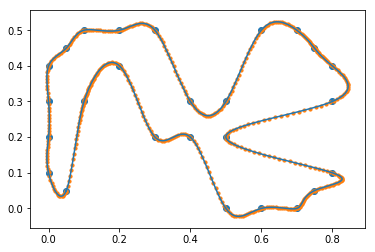

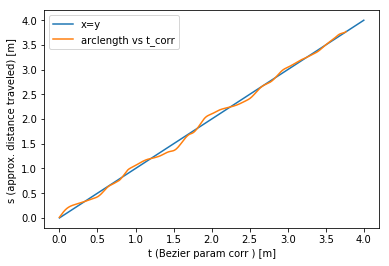

In [57]:
coords_corr = []

for t in t_corr:
    coords_corr.append(evalclosedBezier(waypoints, a, b, t))

coords_corr = np.array(coords_corr)

plt.figure()
plt.plot(coords_corr[:,0],coords_corr[:,1])
plt.scatter(trackx, tracky)
plt.scatter(coords_corr[:,0],coords_corr[:,1], s=10)


dists_corr = []

for idx in range(npoints):
    dists_corr.append(np.sqrt(np.sum(np.square(coords_corr[idx,:]-coords_corr[np.mod(idx+1,npoints-1),:]))))
    
dists_corr = np.cumsum(np.array(dists_corr))

plt.figure()
#plt.plot(tvals, dists)
plt.plot([0, 4], [0, 4])
plt.plot(svals, dists_corr)
plt.legend(["x=y","arclength vs t_corr"])
plt.xlabel("t (Bezier param corr ) [m]")
plt.ylabel("s (approx. distance traveled) [m] ")